# Sentiment Analysis on User Feedbacks

## Objectifs
- Explorer le dataset de feedbacks utilisateurs
- Analyser les ratings numériques
- Extraire le sentiment à partir du texte (NLP)
- Étudier la cohérence entre le rating et le sentiment textuel

Ce notebook constitue la phase exploratoire du projet.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("vader_lexicon")

sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sakkarouis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sakkarouis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/sakkarouis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sakkarouis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df=pd.read_csv("../data/feedbacks.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [4]:
df.describe()


,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [5]:
df.isnull().sum()


Review    0
Rating    0
dtype: int64

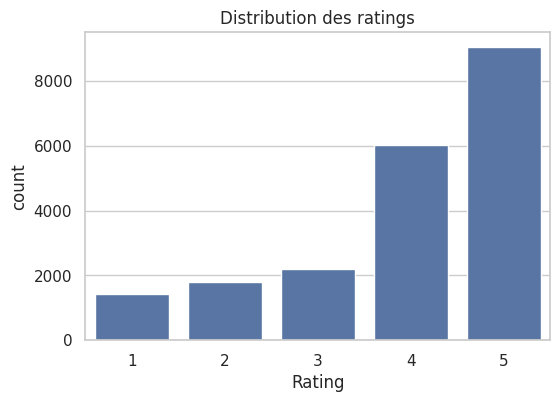

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Rating")
plt.title("Distribution des ratings")
plt.show()


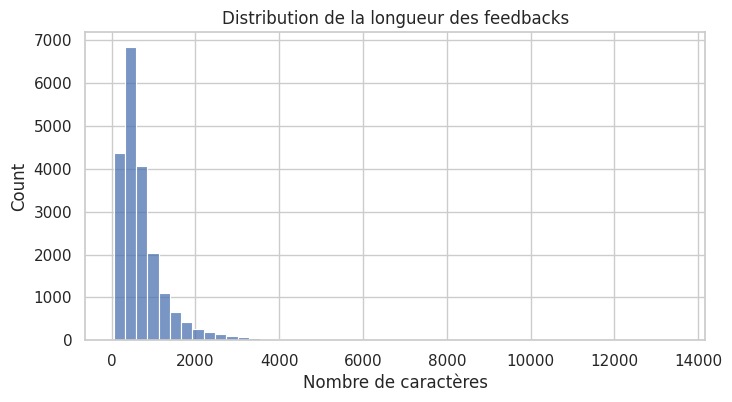

In [7]:
df["text_length"] = df["Review"].astype(str).apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df["text_length"], bins=50)
plt.title("Distribution de la longueur des feedbacks")
plt.xlabel("Nombre de caractères")
plt.show()


In [8]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["clean_text"] = df["Review"].apply(clean_text)

df[["Review", "clean_text"]].head()


,Review,clean_text
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,nothing special charge diamond member hilton d...
2,nice rooms not 4* experience hotel monaco seat...,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...


In [9]:
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["text_sentiment"] = df["clean_text"].apply(vader_sentiment)

df[["clean_text", "text_sentiment"]].head()


,clean_text,text_sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,nothing special charge diamond member hilton d...,positive
2,nice room experience hotel monaco seattle good...,positive
3,unique great stay wonderful time hotel monaco ...,positive
4,great stay great stay went seahawk game awesom...,positive


In [10]:
df

,Review,Rating,text_length,clean_text,text_sentiment
0,nice hotel expensive parking got good deal sta...,4,593,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,2,1689,nothing special charge diamond member hilton d...,positive
2,nice rooms not 4* experience hotel monaco seat...,3,1427,nice room experience hotel monaco seattle good...,positive
3,"unique, great stay, wonderful time hotel monac...",5,600,unique great stay wonderful time hotel monaco ...,positive
4,"great stay great stay, went seahawk game aweso...",5,1281,great stay great stay went seahawk game awesom...,positive
...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,733,best kept secret time staying charm star beat ...,positive
20487,great location price view hotel great quick pl...,4,306,great location price view hotel great quick pl...,positive
20488,"ok just looks nice modern outside, desk staff ...",2,443,look nice modern outside desk staff particular...,positive
20489,hotel theft ruined vacation hotel opened sept ...,1,5557,hotel theft ruined vacation hotel opened sept ...,positive


In [11]:
def rating_to_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

df["rating_sentiment"] = df["Rating"].apply(rating_to_sentiment)

df[["Rating", "rating_sentiment"]].drop_duplicates()


,Rating,rating_sentiment
0,4,positive
1,2,negative
2,3,neutral
3,5,positive
15,1,negative


In [12]:
df["coherent"] = df["text_sentiment"] == df["rating_sentiment"]

df["coherent"].value_counts(normalize=True) * 100


coherent
True     78.112342
False    21.887658
Name: proportion, dtype: float64

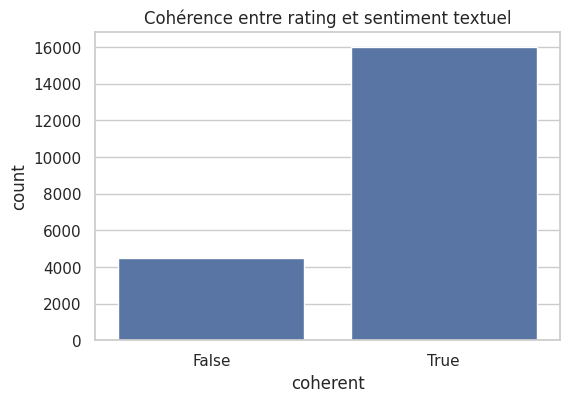

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="coherent")
plt.title("Cohérence entre rating et sentiment textuel")
plt.show()


In [14]:
df[df["coherent"] == False][
    ["Review", "Rating", "rating_sentiment", "text_sentiment"]
].head(10)


,Review,Rating,rating_sentiment,text_sentiment
1,ok nothing special charge diamond member hilto...,2,negative,positive
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,positive
10,"poor value stayed monaco seattle july, nice ho...",2,negative,positive
13,nice hotel not nice staff hotel lovely staff q...,3,neutral,positive
15,horrible customer service hotel stay february ...,1,negative,positive
16,disappointed say anticipating stay hotel monac...,2,negative,positive
19,hmmmmm say really high hopes hotel monaco chos...,3,neutral,positive
24,great location need internally upgrade advanta...,2,negative,positive
25,"n't mind noise place great, read reviews noise...",3,neutral,positive
27,met expectations centrally located hotel block...,3,neutral,positive


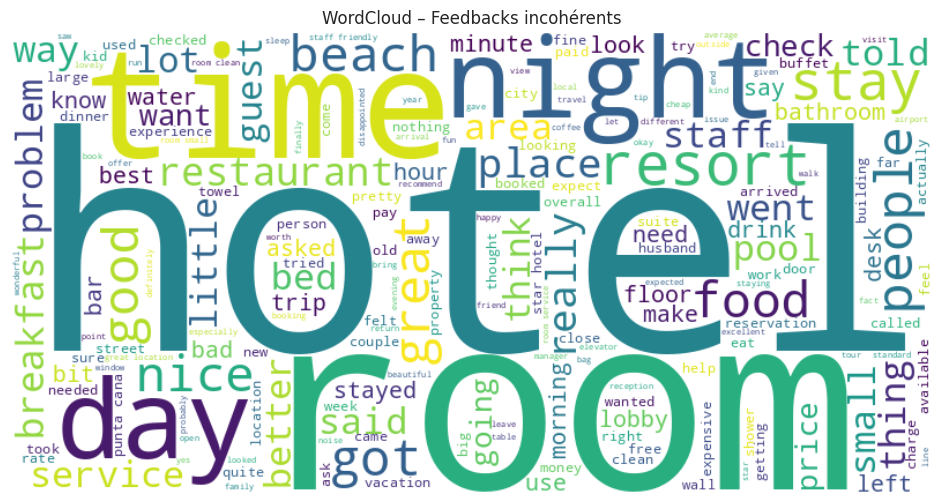

In [15]:
text_incoherent = " ".join(
    df[df["coherent"] == False]["clean_text"]
)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(text_incoherent)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud – Feedbacks incohérents")
plt.show()


In [16]:
df.to_csv("../data/feedbacks_enriched.csv", index=False)

## Conclusion

Cette analyse exploratoire montre que :
- Le sentiment textuel extrait par NLP ne correspond pas toujours au rating numérique
- Une proportion significative de feedbacks est incohérente
- Le rating ne peut pas être utilisé directement comme annotation fiable du sentiment

Ces résultats motivent l'utilisation de modèles NLP supervisés
pour mieux capturer le sentiment exprimé dans le texte.
